$$p(y \vert P, T_0 ,D, \Delta)$$

$$p(y \vert P, T_0 ,D, \Delta) =  \prod_k p(y \vert T_k ,D, \Delta)$$

$$ p(y \vert T_k ,D, \Delta) = \int p(y \vert T_k ,D, \tilde\Delta) \cdot p(\tilde\Delta \vert \Delta) \tilde\Delta$$

$$p(\tilde\Delta \vert \Delta) = N(\Delta, \Sigma) \quad \text{with} \quad  
\frac{1}{\Sigma^2} = \sum_{k}\frac{1}{\sigma_k^2} \quad and \quad
\Delta = \Sigma^2 \sum_{k}{\frac{\Delta_k}{\sigma_k^2}}$$

$$\text{and} \quad p(y \vert T_k ,D, \tilde{\Delta}) = N(\Delta_k, \sigma_k) $$

$$p(y \vert P, T_0 ,D, \Delta) =  \prod_k \int N(\Delta_k, \sigma_k) \cdot N(\Delta, \Sigma) \; d\tilde{\Delta}$$

$$\int N(\Delta_k, \sigma_k) \cdot N(\Delta, \Sigma) \; d\tilde{\Delta} = - \frac{\left(\Delta_{k} - \bar\Delta\right)^{2}}{2 \left(\bar\sigma^{2} + \sigma_{k}^{2}\right)} - \frac{\log{\left(\bar\sigma^{2} + \sigma_{k}^{2} \right)}}{2} - \frac{\log{\left(\pi \right)}}{2} - \frac{\log{\left(2 \right)}}{2}$$

$$\ln(p(y \vert P, T_0 ,D, \Delta)) =  \sum_k - \frac{\left(\Delta_{k} - \bar\Delta\right)^{2}}{2 \left(\bar\sigma^{2} + \sigma_{k}^{2}\right)} - \frac{\log{\left(\bar\sigma^{2} + \sigma_{k}^{2} \right)}}{2} - \frac{\log{\left(\pi \right)}}{2} - \frac{\log{\left(2 \right)}}{2}$$

## The product of two gaussian from sympy

In [1]:
import sympy
from sympy.stats import Normal, density
from sympy import oo

x = sympy.symbols('x', real=True)
a = sympy.symbols(r"\Delta_k", real=True)
b = sympy.symbols(r"\bar\Delta", real=True)
sa = sympy.symbols("\sigma_k", real=True, positive=True)
sb = sympy.symbols(r"\bar\sigma", real=True, positive=True)
amp_a, amp_b = sympy.symbols('A, B', real=True)

In [2]:
A = amp_a * density(Normal("A", a, sa))(x) 
B = amp_b * density(Normal("B", b, sb))(x)
AB = A*B

f_A = sympy.lambdify((x, amp_a, a, sa), A)
f_B = sympy.lambdify((x, amp_b, b, sb), B)
f_sympy_AB_product = sympy.lambdify((x, amp_a, amp_b, a, b, sa, sb), AB)

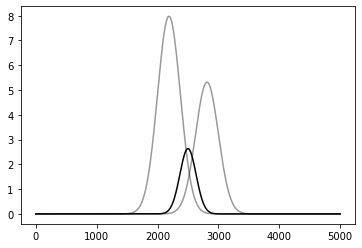

In [3]:
import numpy as np
import matplotlib.pyplot as plt

_a, _b, _s, _amp_a, _amp_b = -0.25, 0.25, 0.15, 3., 2.
_x = np.linspace(-2, 2, 5000)
plt.plot(f_A(_x, _amp_a, _a, _s), c="k", alpha=0.4)
plt.plot(f_B(_x, _amp_b, _b, _s), c="k", alpha=0.4)
plt.plot(f_sympy_AB_product(_x, _amp_a, _amp_b, _a, _b, _s, _s), c="k")

## An analytical version to compare to the product

In [4]:
a_s = sympy.sqrt(1/(1/sa**2 + 1/sb**2))
a_m = (a/sa**2 + b/sb**2)*a_s**2
S = 1/sympy.sqrt(2*sympy.pi*sa**2 * sb**2/a_s**2)*sympy.exp(-(a-b)**2/(2*sa**2 * sb**2) * a_s**2)

analytical_product = amp_a*amp_b*S*density(Normal("A", a_m, a_s))(x)
f_analytical_product = sympy.lambdify((x, amp_a, amp_b, a, sa, b, sb), analytical_product)

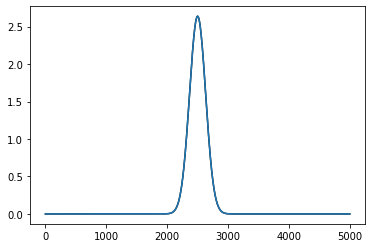

In [5]:
plt.plot(f_sympy_AB_product(_x, _amp_a, _amp_b, _a, _b, _s, _s), c="k")
plt.plot(f_analytical_product(_x, _amp_a, _amp_b, _a, _s, _b, _s))

seems to match

In [6]:
sympy_integral_product = sympy.simplify(sympy.integrate(analytical_product, (x, -oo, oo)))
f_sympy_integral_product = sympy.lambdify((amp_a, amp_b, a, b, sa, sb), sympy_integral_product)

In [7]:
from scipy.integrate import quad

def gauss(x, a=0, va=1.):
    return 1./np.sqrt(2*np.pi*va)*np.exp(-0.5*np.square(a-x)/va)

def integral_product(A, B, a, b, va, vb):
    return np.exp(-0.5 * np.square(a-b)/(va +vb) - 0.5*np.log(va+vb) - 0.5*np.log(np.pi) - np.log(2)/2 + np.log(A) + np.log(B))

_A=0.3; mean_a = 4; va = 1
_B=3.; mean_b = 1; vb = 0.5

def f(x):
    return _A*_B*gauss(x,mean_a, va)*gauss(x, mean_b, vb)

analytic = integral_product(_A, _B, mean_a, mean_b, va, vb)
analytic_sympy = f_sympy_integral_product(_A, _B, mean_a, mean_b, np.sqrt(va), np.sqrt(vb))
numeric, error = quad(f, -np.inf, np.inf)
print(np.abs(analytic - numeric) < error)
print(np.abs(analytic_sympy - numeric) < error)
print(np.abs(analytic_sympy - analytic) < error)

True
True
True


In [225]:
result = sympy.expand_log(sympy.log(sympy_integral_product))
result

-(\Delta_k - \bar\Delta)**2/(2*(\bar\sigma**2 + \sigma_k**2)) + log(A*B) - log(\bar\sigma**2 + \sigma_k**2)/2 - log(pi)/2 - log(2)/2

In [9]:
sympy.simplify(sympy_integral_product)

sqrt(2)*A*B*exp(-(\Delta_k - \bar\Delta)**2/(2*(\bar\sigma**2 + \sigma_k**2)))/(2*sqrt(pi)*sqrt(\bar\sigma**2 + \sigma_k**2))

In [11]:
print(sympy.latex(sympy_integral_product))

\frac{\sqrt{2} A B e^{- \frac{\left(\Delta_{k} - \bar\Delta\right)^{2}}{2 \left(\bar\sigma^{2} + \sigma_{k}^{2}\right)}}}{2 \sqrt{\pi} \sqrt{\bar\sigma^{2} + \sigma_{k}^{2}}}


$$\frac{1}{\sqrt{2\pi \left(\sigma^{2} + \sigma_{k}^{2}\right)}} e^{- \frac{1}{2}\frac{\left(\Delta -  \Delta_{k}\right)^{2}}{\left(\sigma^{2} + \sigma_{k}^{2}\right)}}$$

$$e^{- \frac{\left(\Delta_{k} - \bar\Delta\right)^{2}}{2 \left(\bar\sigma^{2} + \sigma_{k}^{2}\right)}}$$

In [164]:
print(sympy.latex(result))

- \frac{\left(\Delta_{k} - \bar\Delta\right)^{2}}{2 \left(\bar\sigma^{2} + \sigma_{k}^{2}\right)} - \frac{\log{\left(\bar\sigma^{2} + \sigma_{k}^{2} \right)}}{2} - \frac{\log{\left(\pi \right)}}{2} - \frac{\log{\left(2 \right)}}{2}
